# Практическое ДЗ 3

# Задача 1. Томография (40 баллов)

В этом задании мы попробуем построить томограмму некоторого объекта, пользуясь данными об интенсивности лучей, прошедших через него.


In [139]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sparse
import scipy.sparse.linalg as spla


### Генерация данных

Загрузим сечение анализируемой структуры из файла (скачать данные можно по [ссылке](https://disk.yandex.ru/d/d3yQWn9gPD7lJw)). Можно представлять, что мы анализируем, например, альвеолы в лёгких. Или колонию клеток.

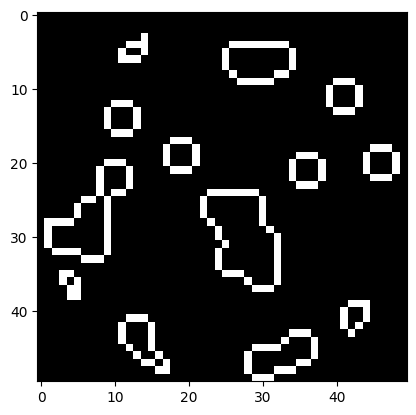

In [140]:
data = np.load("data/tomography.npy")
plt.imshow(data, cmap="gray")
n = data.shape[0]
assert (n, n) == data.shape

Томограф работает так: лучи испускаются из источника, проходят через анализируемую структуру и попадают на детектор (посмотрите картинки по [ссылке](https://plus.maths.org/content/saving-lives-mathematics-tomography)). По интенсивности луча, пришедшего в детектор можно понять, сколько энергии было поглощено по пути. В этой задаче мы будем считать, что количество поглощённой энергии пропорционально количеству пересечённых белых пикселей.

Мы хотим научиться считать величину $p_{\alpha, y}$ &mdash; количество белых пикселей, пересечённых прямой с заданным углом наклона $\alpha$ и проходящих через точку с координатой $(0, y)$ (оси $x,y$ проходят через центр картинки).


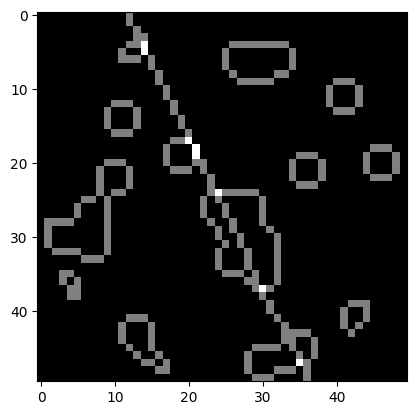

In [141]:
line = np.zeros((n,n))
I = np.arange(n)
J = (I * np.sin(np.pi/6) + n//4).astype(int)
mask = (J >= 0) & (J < n)
line[I[mask], J[mask]] = 1
_ = plt.imshow(data + line, cmap="gray")

Но делать это вычисление мы хотим одновременно для набора углов $\{\alpha_1, \dots, \alpha_s\}$ и набора координат $\{y_1, \dots, y_t\}$. Поэтому мы сформируем матрицу $P$ размера $st \times n^2$, которая при умножении на вытянутую в столбец картинку `data` даст столбец, состоящий из величин $p_{\alpha_i, y_j}$.

Систему координат мы разместим в центре картинки, ось X направим вправо, ось Y вверх. Таким, образом, точка $(x,y)$ примерно соответствует пикселю `data[n//2 - y, x + n//2]`. Реализуем функцию `build_projection_operator`, возвращающую матрицу $P$.

In [142]:
def build_projection_operator(n, alphas, ys):
    P = np.zeros((len(alphas) * len(ys), n**2))
    index = 0
    for alpha in alphas:
        tan = np.tan(alpha)
        cotan = np.tan(np.pi/2 - alpha)
        for y0 in ys:
            if np.abs(tan) <= 1:
                X = np.arange(-n//2, n//2)
                Y = y0 + X * tan
                mask = (Y > -n/2.) & (Y < n/2.)
            else:
                Y = np.arange(-n//2, n//2)
                X = (Y - y0) * cotan
                mask = (X > -n/2.) & (X < n/2.)
            X = np.clip(X + n//2, 0, n - 1)
            Y = np.clip(n//2 - Y, 0, n - 1)
            I = Y[mask].astype(np.int64)
            J = X[mask].astype(np.int64)
            P[index, I + J * n] = 1
            index += 1
    return P

In [143]:
n_alphas = 20
n_ys = 64
alphas = np.linspace(0, np.pi, num=n_alphas, endpoint=False)
ys = np.linspace(-n/2., n/2., num=n_ys)
P = build_projection_operator(n, alphas, ys)
P.shape

(1280, 2500)

Выведем несколько строк матрицы `P` в виде картинок и убедимся, что они соответствуют лучам томографа.

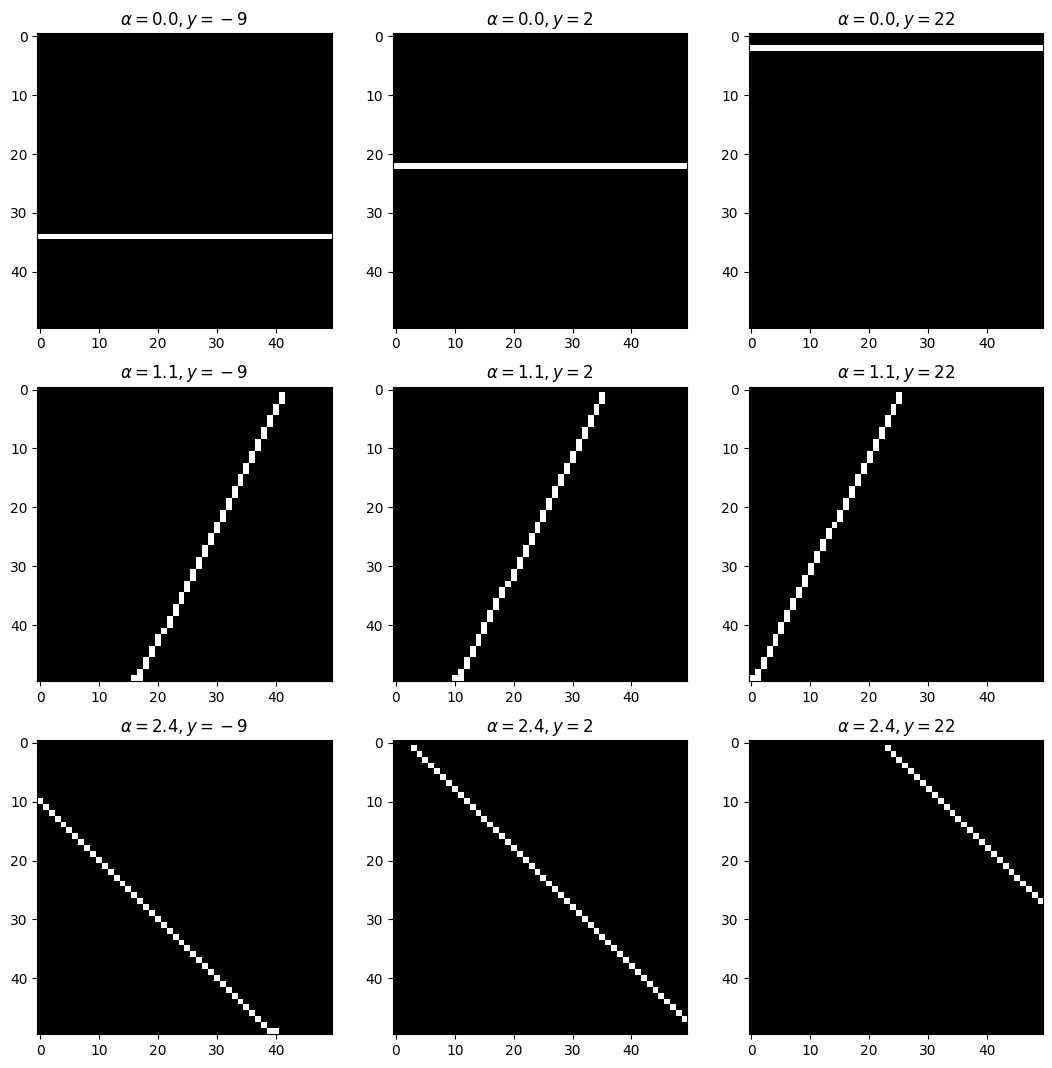

In [144]:
fig, axs = plt.subplots(3, 3, figsize=(13,13))
for i, i_alpha in enumerate([0, 7, 15]):
    for j, i_y in enumerate([20, 35, 60]):
        axs[i,j].imshow(np.reshape(P[i_y +  i_alpha * n_ys, :], (n, n)).T, cmap="gray")
        axs[i,j].set_title("$\\alpha = {:.2}, y = {}$".format(alphas[i_alpha], int(ys[i_y])))

  1. **(4 балла)** Сформируйте проекцию, используя матрицу $P$ и исходную картинку `data`. При вытягивании картинки в столбец используйте такое значение параметра `order`, чтобы этот процесс соответствовал векторизации с лекции.

In [145]:
projection = P @ data.ravel(order="f")

Порешейпим проекцию так, чтобы строки соответствовали углам $\alpha_i$, а столбцы &mdash; сдвигам $y_j$.

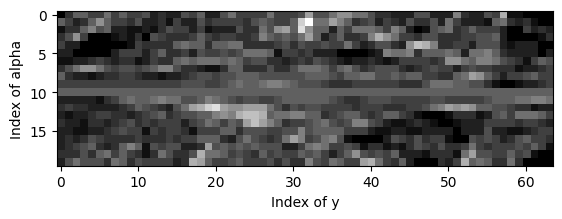

In [146]:
plt.imshow(np.reshape(projection, (n_ys, n_alphas), order="f").T, cmap="gray")
plt.xlabel("Index of y")
_ = plt.ylabel("Index of alpha")

   2. **(По желанию)** Попробуйте объяснить одноцветную линию, соответствующую углу $\alpha = \frac{\pi}{2}$ (горизонтальная линия в середине последнего графика).

### Получение томограммы по проекции

Для восстановления исходной структуры по проекциям, необходимо решить уравнение $Px = b$, где столбец $b$ содержит проекции.
Так как матрица $P$ имеет больше столбцов, чем строк, то система является **недоопределённой**, то есть одни и те же проекции могло дать бесконечно большое количество исходных структур $x$. Если же мы наложим дополнительное требование, чтобы 2-норма вектора $x$ была минимальна, то полученная задача
$$
\|x\|_2 \to \min_{Px=b}
$$
имеет известное решение $x = P^+b$. Поэтому в данном разделе вам необходимо найти псевдообратную матрицу к $P$. Так как в вычислениях с плавающей точкой задача нахождения псевдообратной является некорректно поставленной (из-за того, что сравнение сингулярных чисел с нулём не имеет смысла), то на практике обычно вычисляют $\delta$-псевдообратные матрицы. При их вычислении отбрасываются все сингулярные числа, меньшие $\delta$. Полученная матрица обозначается $P^+_\delta$.

Если исходная матрица имеет много малых сингулярных чисел, то имеет смысл не вычислять $P^+_\delta$ в явном виде, а использовать для вычислений компактное SVD этой матрицы, то есть разложение, в котором матрицы $U$ и $V$ имеют по $\mathrm{rank}(P^+_\delta)$ столбцов. Мы так и поступим.

   3. **(10 баллов)** Напишите функцию `pseudoinverse`, вычисляющую для заданной матрицы $P$ сингулярное разложение её $\delta$-псевдообратной.
Необходимо вернуть компактное SVD матрицы $P^+_\delta$.
Для вычисления используйте сингулярное разложение матрицы $P$. Использовать функцию `np.linalg.pinv` запрещено.

In [147]:
def pseudoinverse_svd(P, threshold=1e-15):
    """
        Input
            A: m x n array
            threshold: smaller singular values are to be dropped
        Output
            U: n x r array with orthonormal columns
            S: array of size r
            VT: r x m array with orthonormal rows
    """
    U, S, VT = np.linalg.svd(P, full_matrices=False)
    r = S > threshold
    U = U[:, r]  # take only columns corresponding to non-zero singular values
    S = S[r]  # take only non-zero singular values
    VT = VT[r, :]  # take only rows corresponding to non-zero singular values
    return VT.T, 1 / S, U.T  # A+ = V * S+ * U.T, S+ = 1/S


Проверим, что псевдообратная совпадает с обратной для квадратной невырожденной матрицы $A$ (случайная матрица с вероятностью, очень близкой к единице, является невырожденной).

In [148]:
A = np.random.random((3, 3))
U, S, VT = pseudoinverse_svd(A)
pinv = np.multiply(U, S) @ VT
assert np.linalg.norm(pinv @ A - np.eye(3)) < 1e-12

   4. **(6 баллов)** С помощью сингулярного разложения $\delta$-псевдообратной к $P$ и вектора `projection` восстановите изображение. Для получения полного балла сложность вычисления восстановленного изображения (без учета SVD) должна быть $O(n^2r + r st)$, где $r = \mathrm{rank}(P^+_\delta)$. Иными словами, нельзя формировать полную матрицу $P^+_\delta$. **Обратите внимание:** дефолтное значение параметра `threshold` не очень подходит для данной задачи, вместо этого рекомендуем использовать `threshold=1`.

In [149]:
U, S, VT = pseudoinverse_svd(P, threshold=1)
reconstructed_pinv = U @ (np.diag(S) @ (VT @ projection))  # A+ = V * S+ * U.T, S+ = 1/S and multiply by projection

Проверьте своё решение: убедитесь, что $\frac{\|P x_{reconstructed} - b\|_2}{\|b\|_2}$ не очень велико, а также выведите в виде изображения вектор `reconstructed_pinv`. На картинке должны достаточно чётко виднеться контуры объектов, особенно близких к центру (**опционально**: можете ли вы неформально объяснить тот эффект, что лучше восстанавливаются объекты, более близкие к центру?)

In [150]:
assert np.linalg.norm(P @ reconstructed_pinv - projection) / np.linalg.norm(projection) < 1e-2

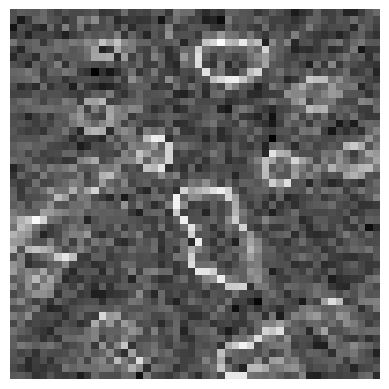

In [151]:
plt.imshow(reconstructed_pinv.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

### Ridge regression

Теперь попробуем подойти к восстановлению изображения с другой стороны: будем решать при фиксированном $\mu > 0$ так называемую $\ell_2$-регуляризованную задачу наименьших квадратов (в англоязычной литературе ridge regression):
$$
\|Px - b\|_2^2 + \mu \|x\|_2^2 \to \min
$$
($b$ здесь означает вектор `projection`).
Смысл состоит в том, что мы хотим, чтобы одновременно и $x$ давала проекцию, похожую на $b$, и при этом сам вектор $x$ не был слишком велик по норме.

Для решения этой задачи запишем условие равенства нулю градиента этой функции:
$$
2(Px-b)^\top P + 2\mu x^\top = 0 \Leftrightarrow (P^\top P + \mu I)x = P^\top b.
$$

   5. **(12 баллов)** Используя компактное SVD $P$, напишите тело функции `ridge_regression`, решающую указанную задачу минимизации для заданных $P$, $b$ и $\mu$. Для получения полного балла не формируйте нигде матриц размером $n^2 \times n^2$.

In [152]:
def ridge_regression(P, b, mu):
    """
        Input
            P: m x n numpy array
            b: numpy array of size m
            mu: regularization coefficient

        Output
            x: numpy array of size n solving ridge regression problem
    """
    U, S, VT = np.linalg.svd(P, full_matrices=False)
    S_inv = S / (S ** 2 + mu)
    return VT.T @ (S_inv * (U.T @ b))


In [153]:
reconstructed_ridge = ridge_regression(P, projection, 1)

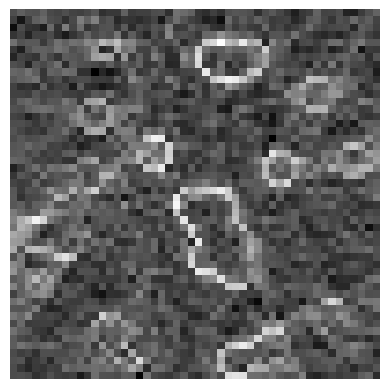

In [154]:
plt.imshow(reconstructed_ridge.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

Обратите внимание, насколько похож результат решения задачи ridge regression на решение с помощью псевдообратной. Это неслучайно: можно показать, что эти два подхода тесно взаимосвязаны, а в пределе при $\mu, \delta \to 0$ дают одинаковые векторы.

### Lasso

Если в ridge regression вместо квадрата второй нормы $x$ использовать первую норму (то есть ставить $\ell_1$-регуляризованную задачу наименьших квадратов), то получится такая задача минимизации:
$$
\|Px-b\|_2^2 + \mu \|x\|_1 \to \min.
$$

Такая задача оказывается более подходящей в нашем случае, так как её решение часто оказывается разреженным (получить некоторую интуицию о том, почему так происходит, можно, например, [тут](https://medium.com/analytics-vidhya/intuition-behind-l1-l2-regularisation-2ac1e6a1bd81); более развёрнутое описание метода есть в [википедии](https://en.wikipedia.org/wiki/Lasso_(statistics))).

   6. **(8 баллов)** Заполните пропуски в теле функции `solve_lasso`. Воспользуйтесь документацией к классу [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).


In [155]:
from sklearn.linear_model import Lasso


def solve_lasso(P, b):
    lasso = Lasso(alpha=0.001)
    lasso.fit(P, b)
    return lasso.coef_

In [156]:
reconstructed_lasso = solve_lasso(P, projection)

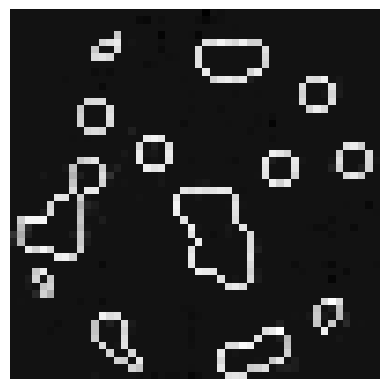

In [157]:
plt.imshow(reconstructed_lasso.reshape(n, n, order='f'), cmap='gray'); _ = plt.axis('off')

Сравним все три полученных решения с исходной структурой.

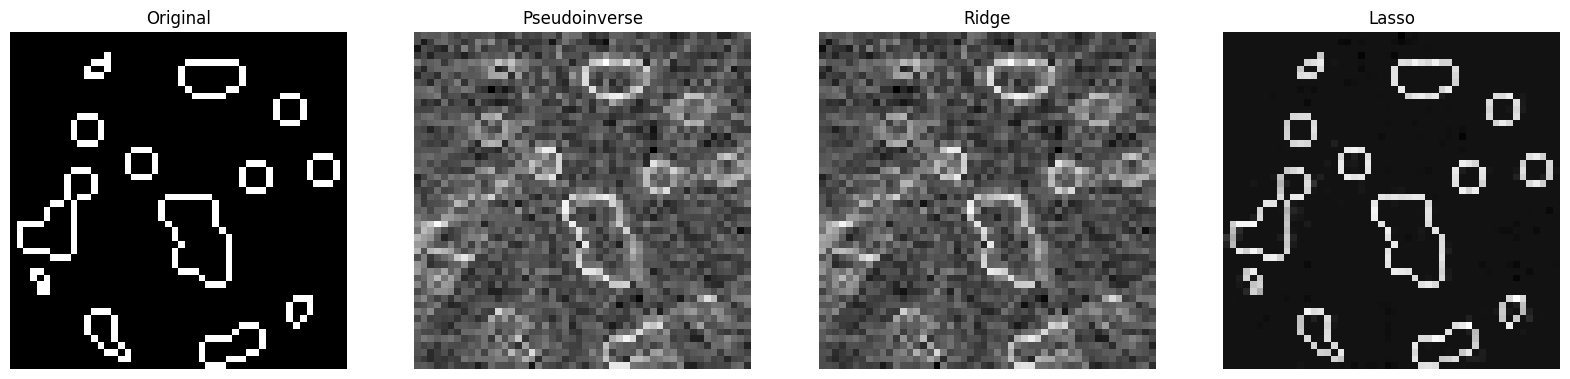

In [158]:
fig, axs = plt.subplots(1,4, figsize=(20,30))
for i, (im, name) in enumerate([
    (data, "Original"),
    (reconstructed_pinv.reshape(n, n, order='f'), "Pseudoinverse"),
    (reconstructed_ridge.reshape(n, n, order='f'), "Ridge"),
    (reconstructed_lasso.reshape(n, n, order='f'), "Lasso"),
]):
    axs[i].imshow(im, cmap="gray")
    axs[i].set_title(name)
    axs[i].axis('off')

# Задача 2. Быстрое вычисление дискретной свертки (60 баллов)

В этой задаче мы научимся эффективно вычислять **свёртку** изображения на примере одного из самых известных фильтров &mdash; фильтра Гаусса (подзадачи a., b., c.), а также попробуем восстановить исходное изображение из размытого (подзадача d.).

**Обратите внимание:** <font color='red'>во всех пунктах данной (и бонусной) задачи запрещается использовать циклы.</font>

Начнем с эффективного применение фильтра Гаусса

Загрузим изображение (в виде матрицы $A$), с которым будем работать. Будем использовать одну из классических фотографий, применяемых для тестирования алгоритмов обработки изображений: "cameraman". 

(256, 256)


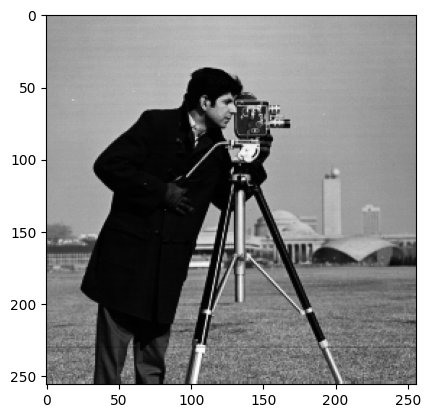

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

A = imread('data/cameraman.tif').astype(np.float64)
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Мы будем учиться применять к картинке [фильтр Гаусса](https://en.wikipedia.org/wiki/Gaussian_blur), чтобы получить в итоге что-то вроде следующего изображения. 

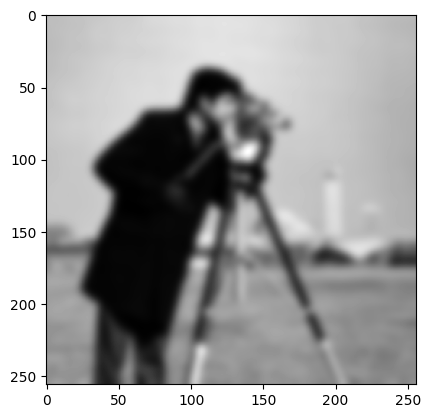

In [160]:
from scipy.ndimage import gaussian_filter
B = gaussian_filter(A, 3)
_ = plt.imshow(B, cmap='gray')

### a. (12 баллов) Формулировка задачи

При это преобразовании каждый пиксель картинки заменяется на взвешенную сумму соседних пикселей (вообще говоря, всех остальных пикселей картинки), причём вес пикселя со смещением $\Delta x$ и $\Delta y$ относительно данного есть
$$
G(\Delta x, \Delta y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x^2 + \Delta y^2}{2\sigma^2}\right).
$$
Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость. Но мы не будем реализовывать этот эффект).

 1. **(12 баллов)** Покажите, что результат $B$ применения такой операции к матрице $A$ можно представить в виде
$$
    B = T_m A T_n^T,
$$
где 
$$
(T_n)_{i,j} = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(i-j)^2}{2\sigma^2}\right).
$$

**Замечание:** формулу для $B$ можно будет использовать в дальнейшем даже если этот пункт не был решен.

Так ну честно в решениях на бумажке я не оч, но не зря у нас пдз))))
B это изображение на которое мы применили фильтр Гаусса, а значит это свертка изображения с фильтром Гаусса. В это время матрица А это наше изображение. Таким образом мы можем представить B как свертку изображения А с фильтром Гаусса. А матрицы Tn и Tm это одномерные Гауссовы фильтры для строк и столбцов соответственно. Так как гауссовская функция сеперабельна то мы можем представить двумерную свертку как произведение одномерных сверток(опред сеперабельности).Ниже код который показывает, что произведение одномерных Гауссовых фильтров равно двумерному Гауссовому фильтру.

In [161]:
import sympy as sp
# Библа для математики с буквами

# Определяем символы
sigma = sp.symbols('sigma')
i, j, x, y = sp.symbols('i j x y')

# Определяем Гауссов фильтр как из задачки выше
G = 1/(2*sp.pi*sigma**2) * sp.exp(-((x - i)**2 + (y - j)**2)/(2*sigma**2))

# Определяем одномерные Гауссовы фильтры для строк и столбцов, так как фильтры накладываются по "всей части" изображения.
Tm_xi = 1/sp.sqrt(2*sp.pi*sigma**2) * sp.exp(-((x-i)**2)/(2*sigma**2)) # Гауссов фильтр для столбцов (ну в целом можно и наоборот тут просто показать что индексы сократятся)
Tn_yj = 1/sp.sqrt(2*sp.pi*sigma**2) * sp.exp(-((y-j)**2)/(2*sigma**2)) # Гауссов фильтр для строк (ну в целом можно и наоборот тут просто показать что индексы сократятся)

# Проверяем, соответствует ли произведение одномерных Гауссовых фильтров двумерному
G_reconstructed = Tm_xi * Tn_yj

# Проверяем, соответствует ли произведение одномерных Гауссовых фильтров двумерному
sp.simplify(G - G_reconstructed)


0

### b. (26 баллов) Имплементация одномерных сверток

1. **(17 баллов)** Реализуйте функцию `convolve_1D`, которая вычисляет $T_m A$ с помощью вложения $T_m$ в циркулянт и использования быстрого преобразования Фурье (```np.fft.fft```). Матрица $T_m$ задаётся с помощью своего первого столбца. При вычислениях нигде не должна возникнуть полная матрица $T_m$.

In [162]:
def convolve_1D(A, T_col):
    """
        Input
            A: m x n matrix
            T_col: array of shape (m,) -- first column of matrix T_m

        Output
            B: m x n matrix, B = T_m @ A
    """
    # Создадим циркулянт из T_col
    c = np.concatenate((T_col, T_col[-1:0:-1]))
    # Дополним матрицу А нулями
    A_padded = np.pad(A, ((0, len(T_col) - 1), (0, 0)))
    # Применим быстрое преобразование Фурье
    C_fft = np.fft.fft(c)
    A_fft = np.fft.fft2(A_padded)
    # Перемножим поэлементно
    product = C_fft[:, np.newaxis] * A_fft  # расширение размерности C_fft для поэлементного умножения
    B = np.fft.ifft2(product)[:A.shape[0]]  # обратное преобразование Фурье и обрезка до размера A
    return B

Напишем также функцию `form_T_col`, которая будет создавать первый столбец матрицы `T_m` для заданных параметров `m` и `sigma`, а также `form_T`, которая будет создавать собственно матрицу $T_m$. Мы будем использовать `form_T` для тестирования правильности вычислений.

In [163]:
from scipy.linalg import toeplitz

def form_T_col(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_col: array of shape (m,) -- first column of T_m, 
                   the matrix of 1D Gaussian filter
    """
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp((-1. / (2 * sigma**2)) * np.arange(m)**2)

def form_T(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_m: m x m matrix of 1D gaussian filter
    """
    return toeplitz(form_T_col(m, sigma))

Теперь мы можем проверить, правильно ли работает функция `convolve_1D`.

In [164]:
B = A[:5,:5]
sigma = 10
m, n = B.shape
T_m_col = form_T_col(m, sigma)
T_m = form_T(m, sigma)
np.linalg.norm(T_m @ B - convolve_1D(B, T_m_col))

3.294703187841625e-14

2. **(2 балла)** Используя тот факт, что быстрое преобразование Фурье вектора длины $n$ вычисляется за $O(n\log n)$, выпишите асимптотику времени работы функции `convolve_1D`.

Вообще мы там и создавали и сокращали матрицы, но в итоге самое дорогое по времени это преоброзование Фурье, которое работает за O(nlogn), но в нашем случае это будет работать за O(mnlog(mn)), так как мы применяем его к матрица m x n.

3. **(5 балла)** Теперь нам понадобится функция `gauss_convolve_1D`, которая сформирует правильный столбец `T_col` и вызовет `convolve_1D`. Параметр `sigma` соответствует гауссовскому стандартному отклонению $\sigma$ из формулы для $G(\cdot)$.

In [165]:
def gauss_convolve_1D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            B: m x n matrix, B = T_m @ A
    """
    T_col = form_T_col(A.shape[0], sigma)
    B = convolve_1D(A, T_col).real
    return B

4. **(2 балла)** Проверим, как работает наша одномерная свёртка на нашей картинке. Должно быть похоже, что каждый столбец размыли. Когда всё получится, попробуйте поиграть параметром `sigma` и объясните, как от него зависит "сила" размытия.

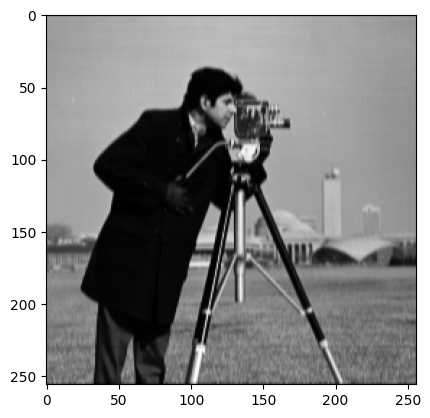

In [166]:
A_conv_1D = gauss_convolve_1D(A, 1)
_ = plt.imshow(A_conv_1D, cmap='gray')

Кстати говоря интересный факт - я с ПАДа и просто заменил свои диффуры на ОМВ пми, то есть это единственный курс который я прохожу не на своей ОП. И вот на нашей ОП нет теории вероятностей и весь год мы изучали aesthetics statistics, которая закончилась вчера. Ну это предисловие, а так настало время мне рассказать про то, что я слышал чаще всего за 2 курс - статистика и что из нее выходит.

Сигма это стандартное отклонение, а значит чем оно больше тем больше размытие. Вот так вот. Ну и вообще это все из-за того что гауссовская функция убывает экспоненциально, а значит чем больше стандартное отклонение тем меньше веса у пикселей, которые дальше от центра. Вот такая простая, но прикольная и полезная (наверн) интепретация у стандартного отклонения.


### c. (10 баллов) Вычисление двумерной свертки

1. **(8 баллов)** Теперь вы уже без труда сможете написать функцию двумерной свёртки: $B = T_m A T_n^T$, используя функцию ```gauss_convolve_1D```.

In [167]:
def gauss_convolve_2D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            С: m x n matrix, B = T_m @ A @ T_n.T
    """
    B_0 = gauss_convolve_1D(A, sigma)
    B = gauss_convolve_1D(B_0.T, sigma).T
    return B

...и визуально проверить, правильно ли она работает.

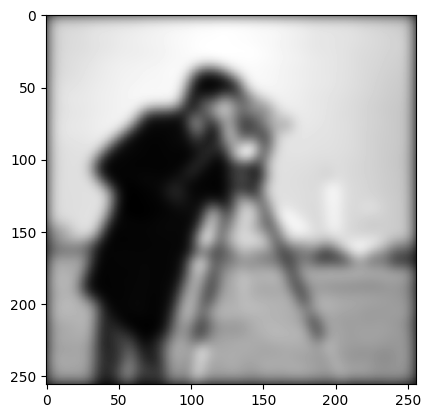

In [168]:
A_conv = gauss_convolve_2D(A, 5)
_ = plt.imshow(A_conv, cmap='gray')

2. **(2 балла)** Объясните эффект тёмных полос около края картинки.

Хороший вопрос. Так как мы не обрабатываем края, то там остаются пиксели с нулевыми значениями, а значит они и остаются темными.

### d. (12 баллов) Обращение свёртки (deconvolution)

Представьте, что к вам попало изображение такого типа. (Заодно оцените на похожесть вашего фильтра со стандратным фильтром из `SciPy`).

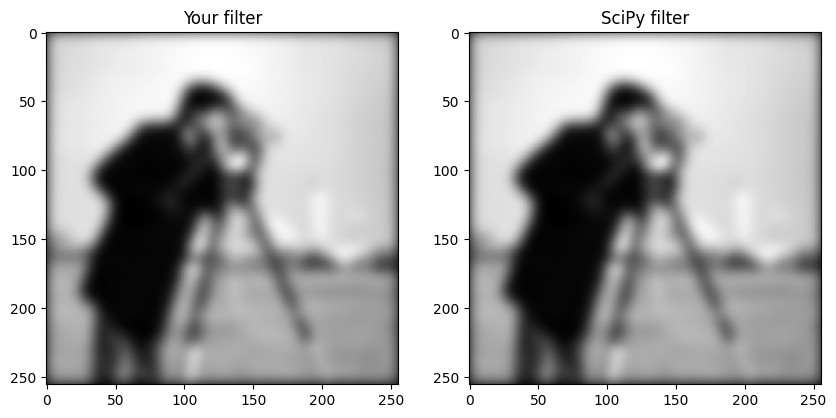

In [169]:
from scipy.ndimage import gaussian_filter
sigma = 5
A_conv = gauss_convolve_2D(A, sigma)
A_conv_scipy = gaussian_filter(A, sigma, mode='constant')
fig = plt.figure(figsize=(10, 7))
rows, columns = 1, 2
fig.add_subplot(rows, columns, 1)
plt.imshow(A_conv.real, cmap='gray')
plt.title('Your filter')
fig.add_subplot(rows, columns, 2)
plt.imshow(A_conv_scipy.real, cmap='gray')
plt.title('SciPy filter')
plt.show()

Деталей не видно совсем. Чтобы восстановить их попробуем применить применить операцию обратную свертке. 
Мы уже знаем, что размытое изображение $A_{conv}$ вычисляется по формуле $A_{conv} = T_m A T_n^\top$.
Если же матрицы $T_m$ и $T_n$ обратимы, то можно обратить свёртку и получить обратно нашего cameraman:
$$
A = T_m^{-1} A_{conv} T_n^{-\top}.
$$

In [170]:
m, n = A_conv.shape
T_m, T_n = form_T(m, sigma), form_T(n, sigma)
B = np.linalg.solve(T_m, A_conv)
A_rec = np.linalg.solve(T_n, B.T).T

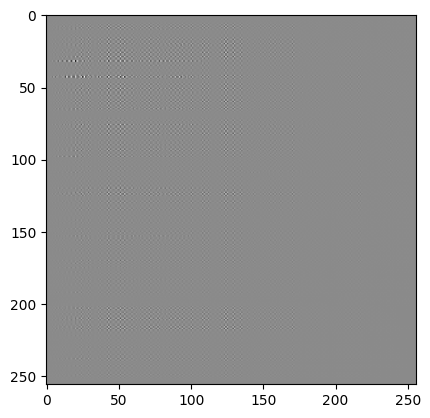

In [171]:
_ = plt.imshow(A_rec, cmap='gray')

Непохоже на исходное изображение. В чём может быть дело?
Давайте выведем сингулярные числа матрицы $G_m$.

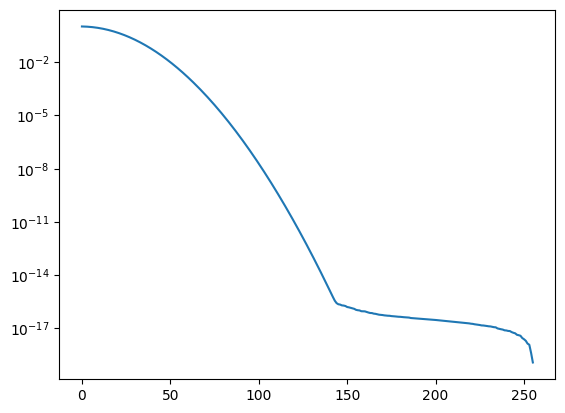

In [172]:
s = np.linalg.svd(T_m, compute_uv=False)
plt.plot(s)
_ = plt.semilogy()

Видно, что у нас большие проблемы (хотя пока мы не умеем это формализовывать), потому что матрица очень близка к вырожденной. Специально для таких матриц у нас есть инструмент псевдообратных матриц, но чтобы оправдать его применение, нужно сначала свести задачу вычисления матрицы $A$ к задаче решения системы линейных уравнений. 
Для этого вспомним формулу, связанную с Кронекеровым произведением: 
$$
\mathrm{vec}(A_{conv}) = (T_n \otimes T_m)\,\mathrm{vec}(A).
$$
Теперь уже можно вычислить "приближённый" $\mathrm{vec}(A)$ с помощью псевдообратных:
$$
\mathrm{vec}(\tilde{A}) = (T_n \otimes T_m)^+ \,\mathrm{vec}(A_{conv})
$$

Конечно, мы не хотим формировать матрицу размеров $mn \times mn$ и работать с ней, поэтому воспользуемся (проверьте) тем фактом, что
$$
(T_n \otimes T_m)^+ = T_n^+ \otimes T_m^+.
$$
Теперь можно перейти обратно к матричной записи: 
$$
\tilde{A} = T_m^+ A_{conv} (T_n^+)^\top.
$$

1. **(12 баллов)** Реализуйте функцию ```inverse_gauss_convolve_2D```, которая реконструирует изображение по "смазанной" картинке $A_{conv}$ с помощью псевдообратных матриц от матриц $T_m$ и $T_n$, у которых занулили сингулярные числа меньше ```tol```. **Замечание:** В данном случае ```np.linalg.pinv``` выдаст всю псевдообратную матрицу, что подойдет в качестве решения. Но можно сделать немного эффективнее, если явно умножать на компоненты компактного SVD.

In [173]:
def inverse_gauss_convolve_2D(A_conv, sigma, tol):
    """
        Input
            conv: m x n matrix -- result of convolution with
                  a Gaussian filter
            sigma: standard deviation of Gaussian filter
            tol: absolute tolerance for cutting singular values in pseudoinverse

        Output
            A_rec: m x n reconstructed matrix, such that approximately A_conv = T_m @ A_rec @ T_n.T
    """
    T_m, T_n = form_T(A_conv.shape[0], sigma), form_T(A_conv.shape[1], sigma)
    A_rec = np.linalg.pinv(T_m, tol) @ A_conv @ np.linalg.pinv(T_n, tol)
    return A_rec

Посмотрим на получившийся результат.

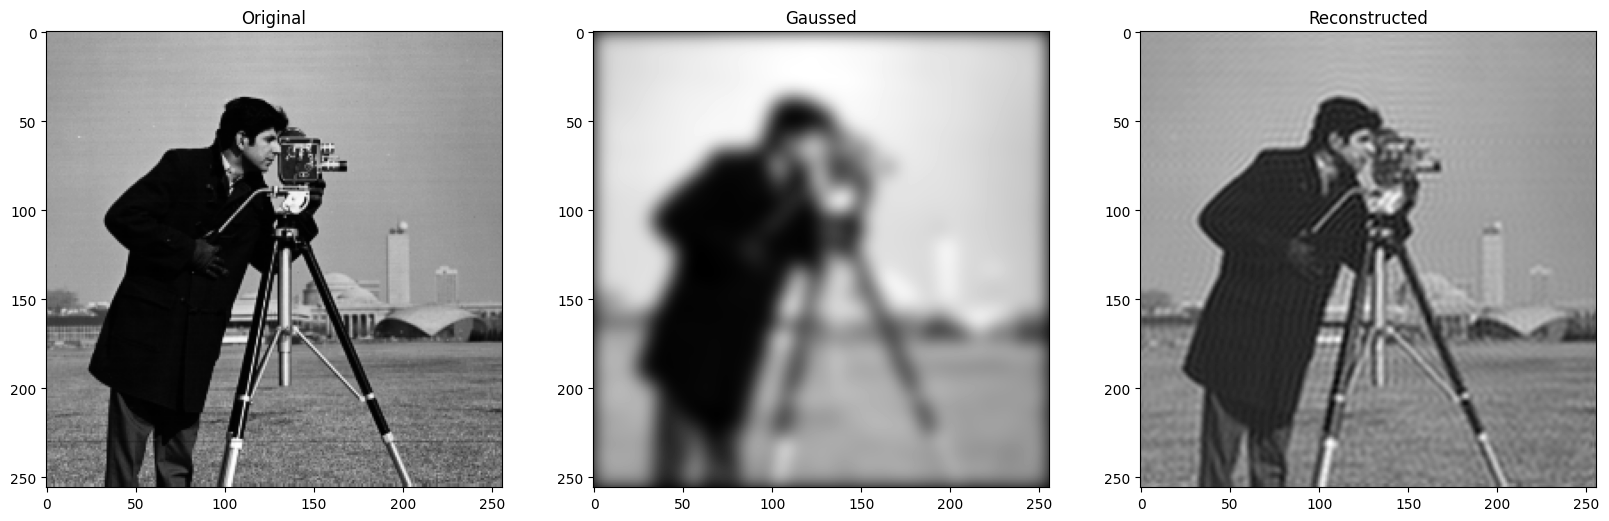

In [174]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(A, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(A_conv, cmap='gray')
axs[1].set_title("Gaussed")
A_rec = inverse_gauss_convolve_2D(A_conv, sigma, 1e-8)
axs[2].imshow(A_rec, cmap='gray')
_ = axs[2].set_title("Reconstructed")